# Notebook of the project of Physics of Complex Systems #
Implementation of this [article](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.031911).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

import model as m       # Python file with all the functions

## Functions

In [2]:
# set the seed
np.random.seed(12345)
# I set some parameters for the whole project
time_steps = 5000    # 1000
# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)
# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.2,   # 1.2
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 0.001,
    'sigma': 0.01,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
# Define some meaningful quantities for the analysis
y0 = par['lambda']/par['sigma']
#y0 = 4 # from Figure 1
y_star = par['alpha']/par['gamma']
x_star = (par['sigma']-par['lambda']*par['gamma']/par['alpha'])/par['nu']
m.stability(par)

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


Firstly, I try to reproduce the mean-field approach. The resulting system of ODEs is the following:
$$
    \frac{\partial x}{\partial t} = \alpha x - \gamma xy , \;\;\;
    \frac{\partial y}{\partial t} = \lambda + \nu xy - \sigma y
$$
where $x$ is the pathogen concentration and $y$ the lymphocytes'. \
The parameters represent:
- $\alpha$ : proliferation rate of the pathogen; 
- $\gamma$ : destruction rate of the pathogen by the lymphocytes; 
- $\lambda$ : birth rate of the lymphocyte; 
- $\nu$ : duplication rate of the lymphocyte when encountering the pathogen; 
- $\sigma$ : death rate of the lymphocyte. 
# Mean Field Approach #

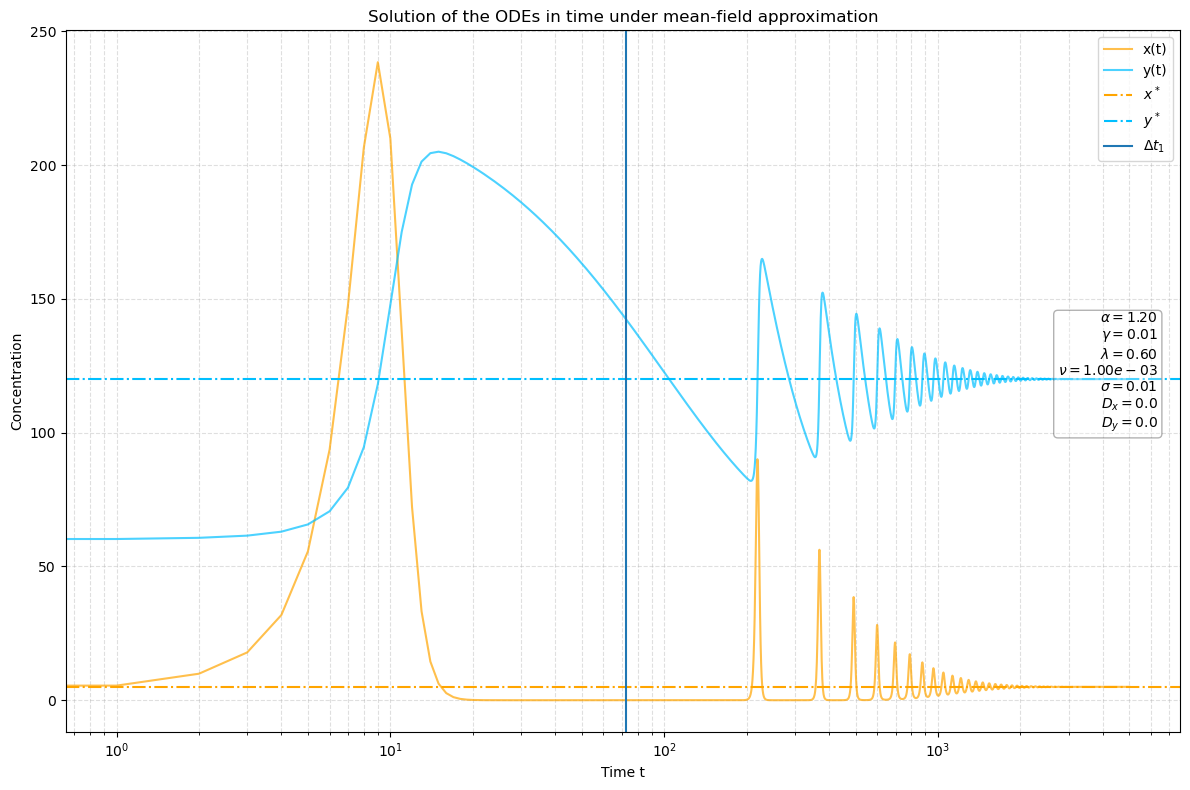

<Figure size 640x480 with 0 Axes>

In [3]:
# set initial conditions
#z0 = np.array([3,np.random.poisson(lam=1)])    # z=[x,y]
#z0 = np.array([x_star,y_star])    # z=[x*,y*] (I try to initialize at a fixed point to verify stability)
z0 = np.array([3,y0])

# Solve
X_ode = odeint(m.system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(m.system,z0,t_s,args=(par,))[:,1]

'''
# Normalization
X_ode /= np.max(X_ode)
Y_ode /= np.max(Y_ode)
'''
y_tilde = Y_ode[np.argmin(np.abs(X_ode-1))]
Dt1 = (1/par['gamma'])*(np.log((y_tilde-
                                par['gamma']/par['sigma'])/
                               (par['alpha']/par['gamma']-
                               par['lambda']/par['sigma'])))

# Solution of the X ODE
plt.figure(figsize=(12,8))
plt.plot(t_s, X_ode, c='orange', label='x(t)',alpha=0.7)
plt.plot(t_s, Y_ode, c='deepskyblue', label='y(t)',alpha=0.7)
plt.title('Solution of the ODEs in time under mean-field approximation')
plt.axhline(y=x_star,label=r'$x^*$',c='orange',linestyle='-.')
plt.axhline(y=y_star,label=r'$y^*$',c='deepskyblue',linestyle='-.')
plt.axvline(Dt1,label=r'$\Delta t_1$')
plt.xlabel('Time t')
plt.ylabel('Concentration')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.savefig('plots/ODE.png')

The time it takes for $y$ to reach $\tilde{y}$, which is the value of $y$ for which $x=1$, is approximately:
$$
\Delta t_1 = \frac{1}{\gamma}\ln\left(\frac{\tilde{y}-\frac{\lambda}{\sigma}}{\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma}}\right)
$$
while, the time it takes for $x$ to increase from 1 to a larger number $k$ is:
$$
\Delta t_2 = \frac{1}{\alpha}\ln k
$$
Now I recreate the trajectory of the solutions of the ODE

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


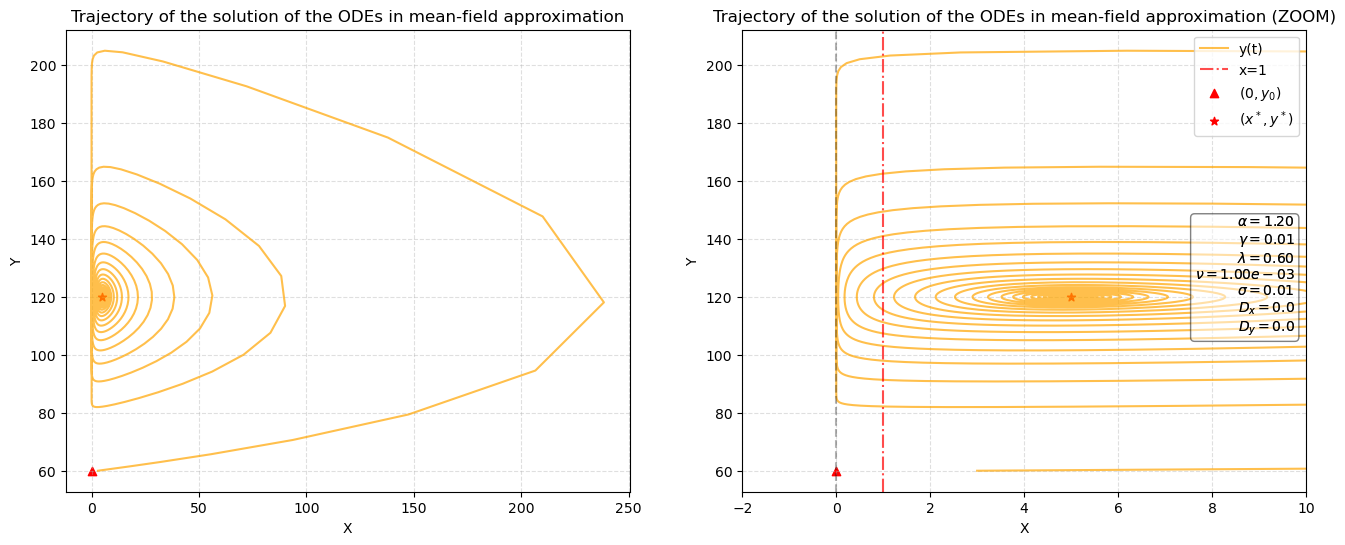

In [4]:
m.stability(par)

fig,ax = plt.subplots(1,2,figsize=(16,6))
# Trajectory of the solutions over time
ax[0].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)

# Trajectory of the solutions over time zoomed
ax[1].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[1].axvline(1,c='r',linestyle='-.',label='x=1',alpha=0.7)
ax[1].axvline(0,c='black',linestyle='--',alpha=0.3)
ax[1].set_title('Trajectory of the solution of the ODEs in mean-field approximation (ZOOM)')
ax[1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1].set_xlim(-2,10)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.savefig('plots/Traj_ODE.png')

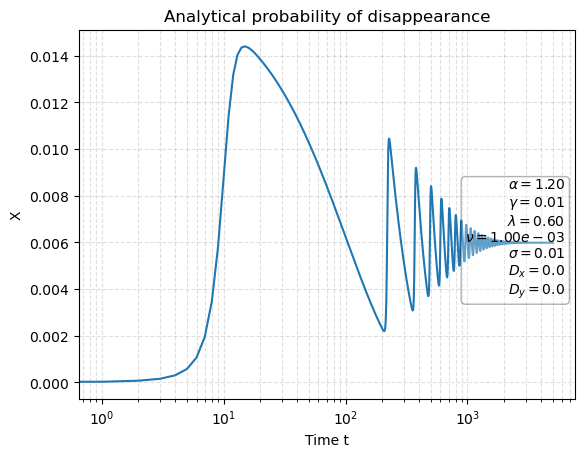

In [5]:
def P_da(x,y,par,y0):
    # this I've obtained from the expression for the disappearance probability at page 4 (see paper notes)
    #return 1-np.exp(-par['gamma']*(par['lambda']+y*(par['nu']*x-par['sigma'])-par['sigma']*y0))
    return 1-np.exp(-par['gamma']*par['sigma']*(y-y0))      # here, as suggested in page 3, I ignore the term $\nu xy$ in y', since x is small.
    #return par['gamma']*y
    
#plt.plot(P_da(X_ode,Y_ode,par,y0)/np.max(P_da(X_ode,Y_ode,par,y0)))
plt.plot(P_da(X_ode,Y_ode,par,y0))
plt.title('Analytical probability of disappearance')
plt.xlabel('Time t')
plt.ylabel('X')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
# Create a box plot for the parameters in 'par'
m.add_par_box(par)

## Lattice ##
The interactions between pathogens and lymphocytes are described by the following reactions:
$$
\begin{gather}
    X \xrightarrow{\alpha} X + X \\
    \emptyset \xrightarrow{\lambda} Y \\
    X + Y \xrightarrow{\gamma} Y  \\
    X + Y \xrightarrow{\nu} X + 2Y \\
    Y \xrightarrow{\sigma} \emptyset .
\end{gather}
$$
### 1D ##
Firstly, I try a toy model of a 1D lattice with 100 cells and no diffusion (mean-field approximation):

In [6]:
par['alpha'] = 1.6
par['nu'] = 0.001
par

{'alpha': 1.6,
 'gamma': 0.01,
 'lambda': 0.6,
 'nu': 0.001,
 'sigma': 0.01,
 'Dx': 0.0,
 'Dy': 0.0}

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


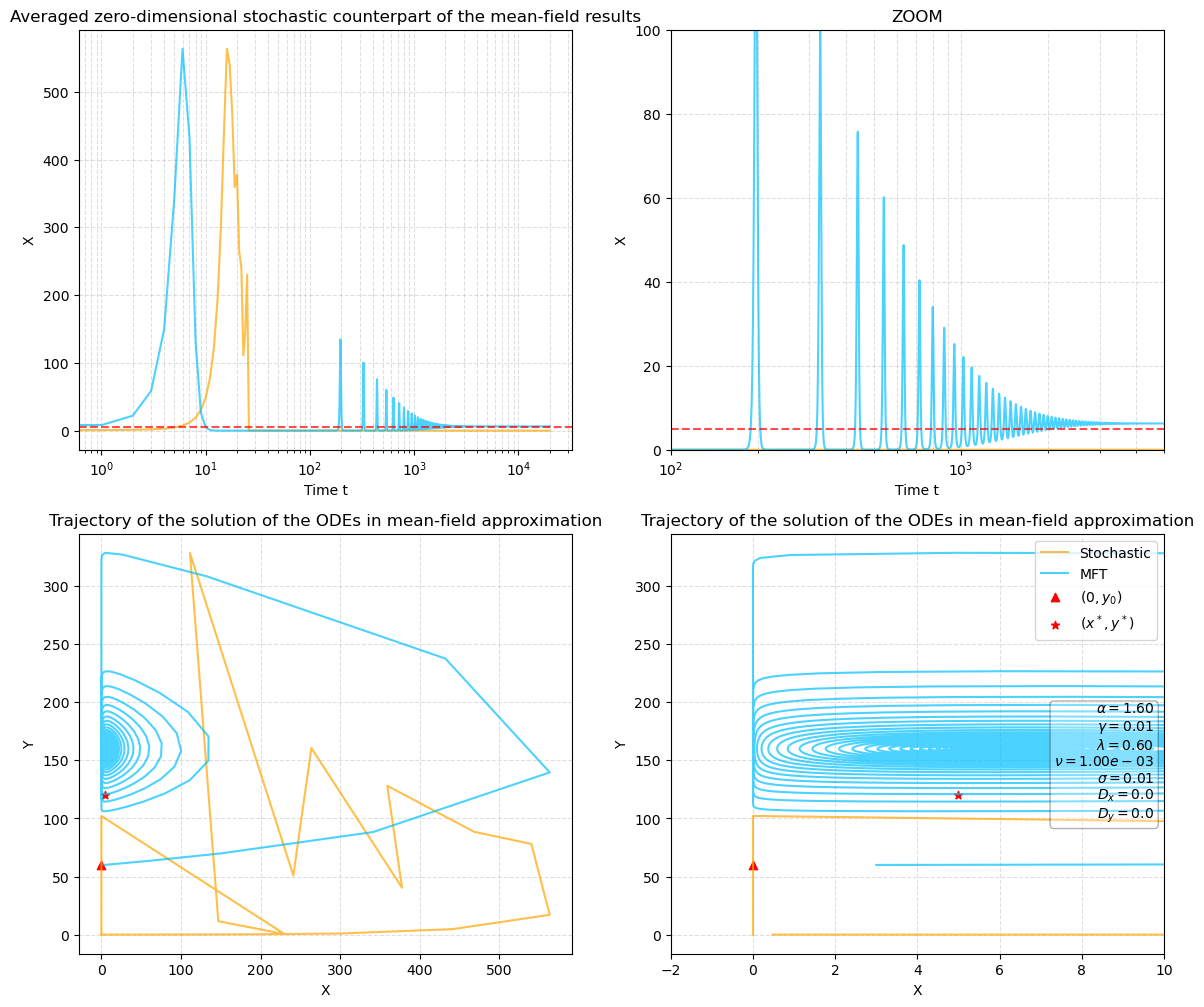

In [7]:
m.stability(par)
# I set some parameters for the whole project
time_steps = 20000    # 1000
# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)
# set initial conditions
z0 = np.array([3,y0])
# Solve again the ODEs so to have it with the right parameters, in case that they're different for the stochastic case
X_ode = odeint(m.system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(m.system,z0,t_s,args=(par,))[:,1]

# Compute the model
X_stoc, Y_stoc = m.lattice1(N=100,time_steps=time_steps,par=par)

scalex = np.max(X_stoc)/np.max(X_ode)
scaley = np.max(Y_stoc)/np.max(Y_ode)
fig, ax = plt.subplots(2,2,figsize=(14,12))
# plot the evolution of x(t)
ax[0,0].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,0].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)          # multiplied by 4 only for scaling
ax[0,0].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,0].set_title('Averaged zero-dimensional stochastic counterpart of the mean-field results')
ax[0,0].set_xlabel('Time t')
ax[0,0].set_ylabel('X')
ax[0,0].set_xscale('log')
ax[0,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[0,1].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,1].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
ax[0,1].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,1].set_title('ZOOM')
ax[0,1].set_xlim(100,5000)
ax[0,1].set_ylim(0,100)
ax[0,1].set_xlabel('Time t')
ax[0,1].set_ylabel('X')
ax[0,1].set_xscale('log')
ax[0,1].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,0].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,0].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[1,0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1,0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')
ax[1,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,1].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,1].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,1].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[1,1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1,1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,1].set_xlim(-2,10)
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')
ax[1,1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.show()

Now I study the disappearance probability at the first pass near zero as a function of the distance between the two stable points.\
I only check for having zero pathogen for the zero-pathogen absorbing state; for now I don't care about Y.

I try to use as the first pass near-zero the moment for whihc $y\sim \alpha / \gamma$. In the paper, this is said to happen after a time $\Delta t_1$:
$$
\Delta t_1 = \frac{1}{\sigma}\ln\left[\frac{(\tilde{y} - \frac{\lambda}{\sigma})}{
(\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma})}\right]
$$
where $\tilde{y}$ is the value of $y$ for which $x=1$.\
Such value, we can either extract it analitically from the ODEs or we can retrieve it through simulations. \
As a first approach, we will do the former.

In [8]:
par['alpha'] = 1.2
par['gamma'] = 0.1
par['lambda'] = 0.4
par['sigma'] = 0.1
par

{'alpha': 1.2,
 'gamma': 0.1,
 'lambda': 0.4,
 'nu': 0.001,
 'sigma': 0.1,
 'Dx': 0.0,
 'Dy': 0.0}

In [9]:
'''
P_diss = m.P_diss(m.lattice1,num_nu=100,n_iter=50,N=10000,time_steps=400,par=par)

plt.figure(figsize=(12,8))
plt.plot(P_diss[:,0],P_diss[:,1],c='orange')
plt.xscale('log')
plt.title('Probability of disappearance vs distance between the fixed points')
plt.xlabel('Distance between fixed points')
plt.ylabel('Probability of disappearance')
plt.grid(True, which='both',alpha=0.7)
#plt.savefig('plots/Pdiss.png')
plt.show()
'''

"\nP_diss = m.P_diss(m.lattice1,num_nu=100,n_iter=50,N=10000,time_steps=400,par=par)\n\nplt.figure(figsize=(12,8))\nplt.plot(P_diss[:,0],P_diss[:,1],c='orange')\nplt.xscale('log')\nplt.title('Probability of disappearance vs distance between the fixed points')\nplt.xlabel('Distance between fixed points')\nplt.ylabel('Probability of disappearance')\nplt.grid(True, which='both',alpha=0.7)\n#plt.savefig('plots/Pdiss.png')\nplt.show()\n"

## Diffusion
Now diffusion is added to the stochastic model. In particular, we have an isotropic discrete diffusion regulated by two coefficients, $D_{x}$ and $D_{y}$, for the two populations, respectively pathogens ($x$) and immune system ($y$). The diffusive process is carried out as a Poisson number with mean, e.g. for the pathogen population, $\lambda=D_{x}x$ (where $x$ is the population of the starting site), subtracted from the starting site and added to its neighbours. 

In [10]:
par['alpha']=1.6
par['gamma']=0.01
par['lambda']=0.6
par['nu']=0.001
par['sigma']=0.01
par

{'alpha': 1.6,
 'gamma': 0.01,
 'lambda': 0.6,
 'nu': 0.001,
 'sigma': 0.01,
 'Dx': 0.0,
 'Dy': 0.0}

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


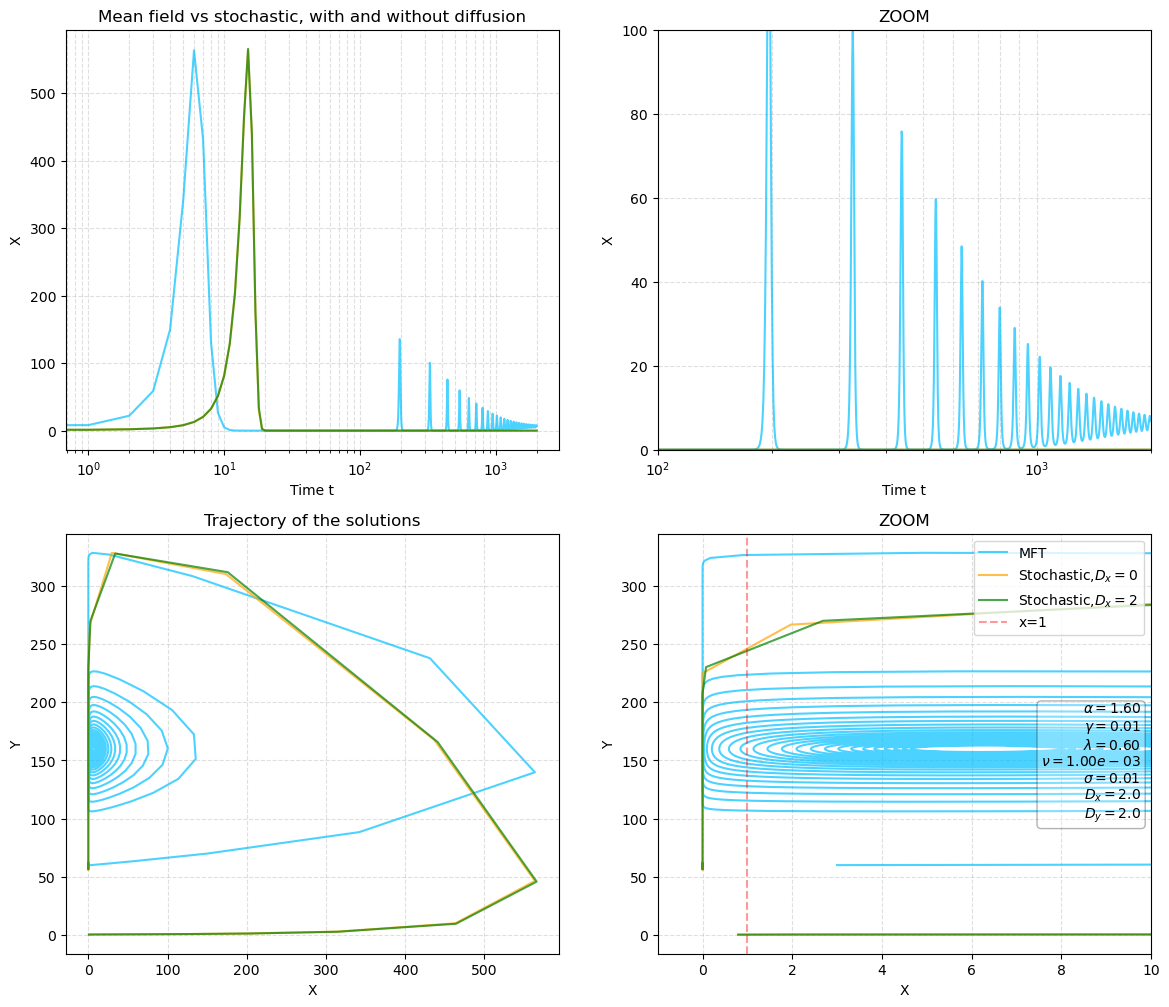

In [13]:
m.stability(par)
# I set some parameters for the whole project
time_steps = 2000    # 1000
# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)
# set initial conditions
z0 = np.array([3,y0])
# Solve again the ODEs so to have it with the right parameters, in case that they're different for the stochastic case
X_ode = odeint(m.system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(m.system,z0,t_s,args=(par,))[:,1]
# Stochastic model with NO DIFFUSION
X_stoc, Y_stoc = m.lattice1(N=10000,time_steps=time_steps,par=par)
# Stochastic model with DIFFUSION on x
par['Dx']=2
par['Dy']=2
X_diff, Y_diff = m.lattice1(N=10000,time_steps=time_steps,par=par)

scalex = np.max(X_stoc)/np.max(X_ode)
scaley = np.max(Y_stoc)/np.max(Y_ode)
fig, ax = plt.subplots(2,2,figsize=(14,12))
# plot the evolution of x(t)
ax[0,0].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)          # multiplied by 4 only for scaling
ax[0,0].plot(X_stoc/scalex,c='orange',label=r'x(t)-Stochastic,$D_{x}=0$',alpha=0.7)
ax[0,0].plot(X_diff/scalex,c='green',label=r'x(t)-Stochastic,$D_{x}=2$',alpha=0.7)
ax[0,0].set_title('Mean field vs stochastic, with and without diffusion')
ax[0,0].set_xlabel('Time t')
ax[0,0].set_ylabel('X')
ax[0,0].set_xscale('log')
ax[0,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[0,1].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
ax[0,1].plot(X_stoc/scalex,c='orange',label=r'x(t)-Stochastic,$D_{x}=0$',alpha=0.7)
ax[0,1].plot(X_diff/scalex,c='green',label=r'x(t)-Stochastic,$D_{x}=2$',alpha=0.7)
#ax[0,1].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,1].set_title('ZOOM')
ax[0,1].set_xlim(100,time_steps)
ax[0,1].set_ylim(0,100)
ax[0,1].set_xlabel('Time t')
ax[0,1].set_ylabel('X')
ax[0,1].set_xscale('log')
ax[0,1].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,0].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,0].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label=r'Stochastic,$D_{x}=0$',alpha=0.7)
ax[1,0].plot(X_diff/scalex, Y_diff/scaley, c='green', label=r'Stochastic,$D_{x}=2$',alpha=0.7)
ax[1,0].set_title('Trajectory of the solutions')
#ax[1,0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
#ax[1,0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')
ax[1,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,1].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,1].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label=r'Stochastic,$D_{x}=0$',alpha=0.7)
ax[1,1].plot(X_diff/scalex, Y_diff/scaley, c='green', label=r'Stochastic,$D_{x}=2$',alpha=0.7)
ax[1,1].set_title('ZOOM')
#ax[1,1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
#ax[1,1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,1].axvline(x=1,c='r',label='x=1',linestyle='--',alpha=0.4)
ax[1,1].set_xlim(-1,10)
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')
ax[1,1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.savefig('plots/diffusion1d.png')
plt.show()

# Direct Percolation

Parameters set #0...


Parameters set #1...
Parameters set #2...
Parameters set #3...
Parameters set #4...
Parameters set #5...
Parameters set #6...
Parameters set #7...
Parameters set #8...
Parameters set #9...


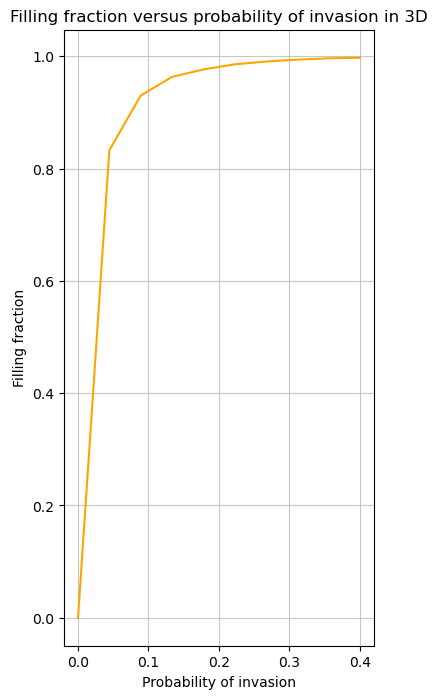

In [ ]:
n_iter = 50     # number of iterations per set of parameters
Pspan = np.linspace(0,0.4,100)     # set of probabiilty of invasion
dim = 3
models = [m.DP1d,m.DP2d,m.DP3d]
params = [22, 500, 0.05, 50]      # [N, timesteps, Pdis, n_iter]
fillings = m.filling_fraction(model=models[dim-1],Pspan=Pspan,params=params)

plt.figure(figsize=(4,8))
plt.plot(fillings[0,:],fillings[1,:],c='orange')
plt.title(f'Filling fraction versus probability of invasion in {dim}D')
plt.xlabel('Probability of invasion')
plt.ylabel('Filling fraction')
plt.grid(True,which='both',alpha=0.7)
plt.savefig(f'plots/filling{dim}D.png')
plt.show()